In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [58]:
import sys
sys.path.append('../modules')
from ObsModels import DiscreteMarkovChain as DMC
import fun

In [55]:
NSteps = 1000
RateMatrix = np.array([[100, 100, 0.1],
                       [100, 100, 10],
                       [1, 0.01, 100]])

DMC1 = DMC(NSteps, RateMatrix)

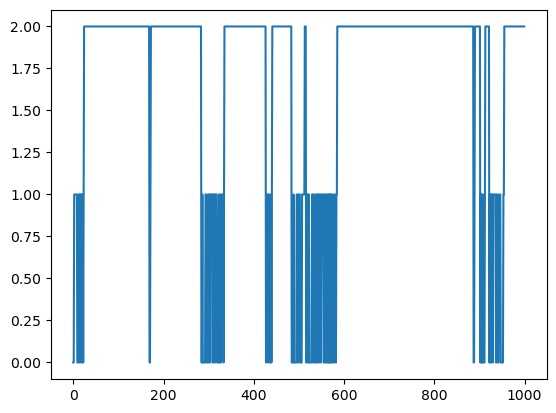

In [56]:
plt.plot(DMC1)

In [75]:
M = 3
A = 3
Y = 2

theta = np.random.randn(Y, M, M, A)
TMat = fun.softmax(theta, axis = (2, 3))

In [76]:
TMat[1, 0].sum()

1.0

In [77]:
MSpace = np.arange(M)
ASpace = np.arange(A)
MASpace = np.array(np.meshgrid(MSpace, ASpace)).T.reshape(-1, 2)
MASpace

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

# PSI OPT

# Finite State Controller with $M = 2$, $A = 2$, $Y = 5$

# Observations, one step

In [ ]:
NStepsObs = 1
NTraj = 500
Y = 5
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [ ]:
M = 2
A = 2

np.random.seed(8734)
Theta = np.random.randn(Y, M, M, A)

Psi = np.array([1.25, 1])

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 5 observations.


In [ ]:
FSC.load_observations(observations)

In [ ]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

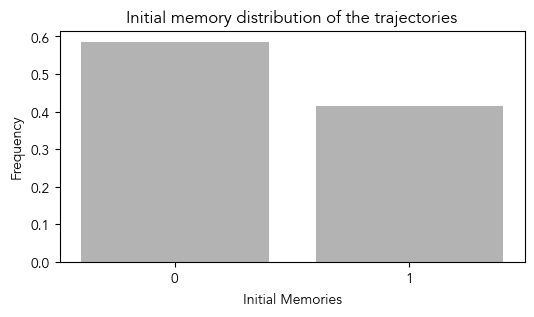

In [ ]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [ ]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.4866512640119291

### Inference

In [ ]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.8743, device='mps:0', grad_fn=<SubBackward0>)

In [ ]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [ ]:
tloss, vloss = FSC_tofit.optimize_psionly(NEpochs = 40, NBatch = 100, lr = 0.2, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
	 Epoch 1 - Batch 1 - Loss: 0.7698332214355469 - Learning rate: 0.2
	 Epoch 1 - Batch 2 - Loss: 0.714845962524414 - Learning rate: 0.2
	 Epoch 1 - Batch 3 - Loss: 0.6702141571044922 - Learning rate: 0.2
	 Epoch 1 - Batch 4 - Loss: 0.6611512756347656 - Learning rate: 0.2
Epoch 1 - Training loss: 0.7040111541748046, Validation loss: 0.6314100839197636
	 Epoch 2 - Batch 1 - Loss: 0.6302373886108399 - Learning rate: 0.18000000000000002
	 Epoch 2 - Batch 2 - Loss: 0.7171786499023437 - Learning rate: 0.18000000000000002
	 Epoch 2 - Batch 3 - Loss: 0.7366289520263671 - Learning rate: 0.18000000000000002
	 Epoch 2 - Batch 4 - Loss: 0.6752102661132813 - Learning rate: 0.18000000000000002
Epoch 2 - Training loss: 0.689813814163208, Validation loss: 0.6226141440868378
	 Epoch 3 - Batch 1 - Loss: 0.7171270751953125 - Learning rate: 0.16200000000000003
	 Epoch 3 - Batch 2 - Loss: 0.6815667724609376 - Learning rate: 0.1620000000000

### Comparison

In [ ]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 5 observations.


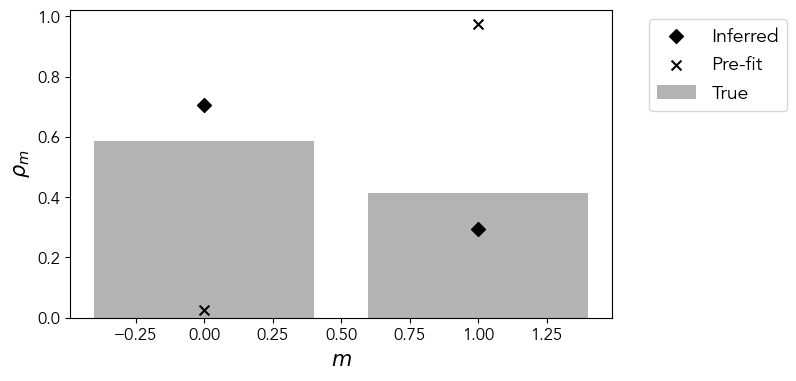

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Finite State Controller with $M = 10$, $A = 6$, $Y = 5$

# Observations, one step

In [ ]:
NStepsObs = 1
NTraj = 5000
Y = 4
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [ ]:
M = 10
A = 6

np.random.seed(0)
Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 10 memory states, 6 actions, and 4 observations.


In [ ]:
FSC.load_observations(observations)

In [ ]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

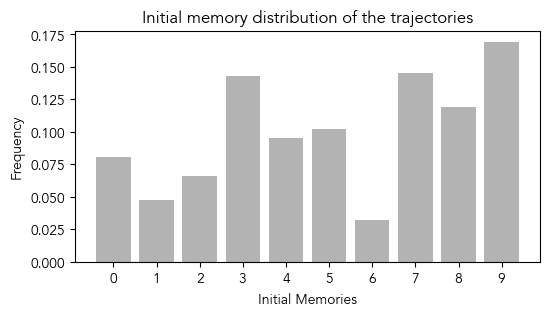

In [ ]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [ ]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.7133769256649671

### Inference

In [ ]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.6356, device='mps:0', grad_fn=<SubBackward0>)

In [ ]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [ ]:
tloss, vloss = FSC_tofit.optimize_psionly(NEpochs = 10, NBatch = 100, lr = 0.01, gamma = 0.99)

Training with 4000 trajectories and validating with 1000 trajectories.
Epoch 1 - Training loss: 1.7892997169494627, Validation loss: 1.7906212328672408 - Learning rate: 0.01
Epoch 2 - Training loss: 1.7876528549194333, Validation loss: 1.7902286769151687 - Learning rate: 0.0099
Epoch 3 - Training loss: 1.7866581764221192, Validation loss: 1.7899165016412735 - Learning rate: 0.009801
Epoch 4 - Training loss: 1.7859989852905271, Validation loss: 1.7898649661540984 - Learning rate: 0.00970299
Epoch 5 - Training loss: 1.7856485366821289, Validation loss: 1.789718337059021 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 1.7853236961364747, Validation loss: 1.7897704738378524 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 1.7852304611206056, Validation loss: 1.789953742980957 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 1.785110607147216, Validation loss: 1.7899801142215728 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 1.784999950408936, Validati

### Comparison

In [ ]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 10 memory states, 6 actions, and 4 observations.


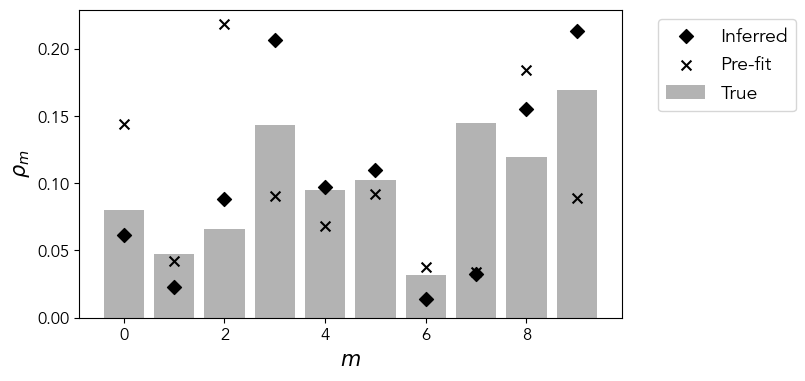

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Gradient-based solution

In [ ]:
def fun_arg_rho_tilde(psi, wVec):
    qVec = np.exp(psi)
    return wVec/(wVec*qVec).sum(axis = -1)[..., None]

def fun_to_min(psi, wVec, pya):
    arg_rho_tilde = fun_arg_rho_tilde(psi, wVec)
    return np.sum(pya[..., None]*arg_rho_tilde, axis = (0,1)) - 1/np.sum(np.exp(psi))

def fun_MSE(psi, wVec, pya):
    MSE = fun_to_min(psi, wVec, pya)**2
    return np.sum(np.sqrt(MSE))

def fun_jac(psi, wVec, pya):
    M = len(psi)
    qVec = np.exp(psi)
    norm = (wVec*qVec).sum(axis = -1)

    jac = np.zeros((M, M))

    for nu in range(M):
        for mu in range(M):
            temp = wVec[:, :, mu]*wVec[:, :, nu]*np.exp(psi[nu])
            temp /= norm**2

            jac[mu, nu] = -np.sum(pya*temp)
    
    return jac

# def MSE_jac(psi, c, wVec, pya):

#     f = fun_to_min(psi, c, wVec, pya)
#     jac = fun_jac(psi, wVec, pya)

#     fsqrt = f/np.sqrt(f**2)

#     return np.sum(fsqrt*jac, axis = 0)


# def fun_hess(psi, wVec, pya):
#     M = len(psi)
#     qVec = np.exp(psi)
#     norm = (wVec*qVec).sum(axis = -1)

#     jac = fun_jac(psi, wVec, pya)
#     hess = np.zeros((M, M, M))

#     for nu in range(M):
#         for mu in range(M):
#             for beta in range(M):
#                 temp = wVec[:, :, mu]*wVec[:, :, nu]*wVec[:, :, beta]*np.exp(psi[nu])*np.exp(psi[beta])
#                 temp /= norm**4

#                 hess[mu, nu, beta] = -2*np.sum(pya*temp)

#                 if beta == nu:
#                     hess[mu, nu, beta] += jac[mu, nu]
    
#     return jac

# def MSE_hess(psi, c, wVec, pya):

#     f = fun_to_min(psi, c, wVec, pya)
#     jac = fun_jac(psi, wVec, pya)
#     hes = fun_hess(psi, wVec, pya)

#     return 2*np.dot(jac.T, jac) + 2*np.sum(f[..., None, None]*hes, axis = 0)

In [ ]:
from scipy.optimize import minimize

def fun_arg_rho_tilde(rhoVec, wVec):
    return wVec/(wVec*rhoVec).sum(axis = -1)[..., None]

def fun_to_min(psi, wVec, pya):
    rhoVec = np.exp(psi)
    rhoVec /= rhoVec.sum()

    arg_rho_tilde = fun_arg_rho_tilde(rhoVec, wVec)
    
    return np.sum(pya[..., None]*arg_rho_tilde*rhoVec[None, ...], axis = (0,1)) - rhoVec

def fun_MSE(psi, wVec, pya):
    MSE = fun_to_min(psi, wVec, pya)**2
    return np.sum(np.sqrt(MSE))

def fun_jac_rho(rhoVec):
    M = len(rhoVec)
    jac = np.zeros((M, M))
    for mu in range(M):
        for nu in range(M):
            if mu == nu:
                jac[mu, nu] = rhoVec[mu] - rhoVec[mu]*rhoVec[nu]
            else:
                jac[mu, nu] = -rhoVec[mu]*rhoVec[nu]
    
    return jac

def jac_fun(psi, wVec, pya):
    rhoVec = np.exp(psi)
    rhoVec /= rhoVec.sum()

    arg_rho_tilde = fun_arg_rho_tilde(rhoVec, wVec)
    jac_rho = fun_jac_rho(rhoVec)

    jac = np.zeros((M, M))

    for mu in range(M):
        for nu in range(M):
            temp = arg_rho_tilde[:, :, mu]*(jac_rho[mu, nu] + rhoVec[mu]*rhoVec[nu])
            temp -= arg_rho_tilde[:, :, mu]*arg_rho_tilde[:, :, nu]*rhoVec[mu]*rhoVec[nu]
            
            temp = np.sum(pya*temp)

            jac[mu, nu] = temp - jac_rho[mu, nu]

    return jac

def jac_MSE(psi, wVec, pya):
    M = len(psi)
    jac = jac_fun(psi, wVec, pya)
    f = fun_to_min(psi, wVec, pya)
    fsqrt = f/np.sqrt(f**2)
    
    j = np.zeros(M)

    for nu in range(M):
        for mu in range(M):
            j[nu] += fsqrt[mu]*jac[mu, nu]

    return j

ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories])
pya_emp, _, _ = np.histogram2d(ya_array[:,0], ya_array[:,1], bins = [np.arange(-0.5, Y+0.5, 1), np.arange(-0.5, A+0.5, 1)])
pya_emp /= np.sum(pya_emp)

psi0 = np.zeros(M)
wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)

# constraint such that the sum of the abs of psi is less than 10
# constraints = ({'type': 'ineq', 'fun': lambda x: M - np.sum(np.abs(x))}) 

res = minimize(fun_MSE, psi0, args = (wVec, pya_emp),
               jac = jac_MSE, method='trust-ncg',
               hess = '2-point', options = {'maxiter': 2000, 'verbose': 0})

/Users/giorgionicoletti/miniconda3/envs/torch/lib/python3.12/site-packages/scipy/optimize/_minimize.py:732: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_trust_ncg(fun, x0, args, jac, hess, hessp,


In [ ]:
pya_emp.shape

(4, 6)

In [ ]:
fun_MSE(FSC.psi, wVec, pya_emp)

0.004883349605455216

In [ ]:
fun_MSE(res.x, wVec, pya_emp)

0.002879116948014744

In [ ]:
psi_opt = res.x
print(psi_opt)

[-0.39264116  0.2214232  -0.37504332  0.33903017  0.08544404  0.12858726
 -0.58067249 -0.20039766 -0.07001625  0.84428622]


In [ ]:
import fun

rho_opt = fun.softmax(psi_opt)

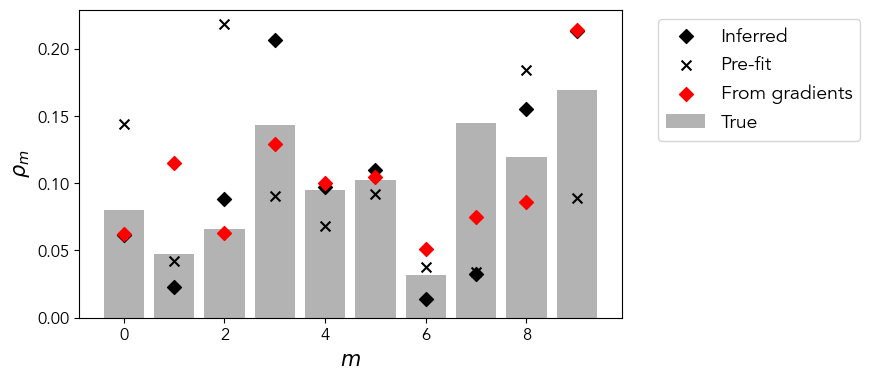

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")
ax.scatter(np.arange(M), rho_opt, color = "red", marker = "D", s = 50, label = "From gradients")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Analytic tests

In [ ]:
NStepsObs = 1
NTraj = int(5e6)

RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)

In [ ]:
FSC.load_observations(observations)

In [ ]:
NSteps = NStepsObs
trajectories_all = FSC.generate_trajectories(NSteps)

In [ ]:
ya_array = np.array([[tr['observations'][0], tr['actions'][0]]  for tr in trajectories_all])

# this is the conditional probability of the action given the observation
pAgY = np.zeros((Y, A))

for y in range(Y):
    pAgY[y] = np.histogram(ya_array[ya_array[:,0] == y, 1], bins = np.arange(-0.5, A+0.5, 1))[0]

    # normalize

    pAgY[y] = pAgY[y]/np.sum(pAgY[y])

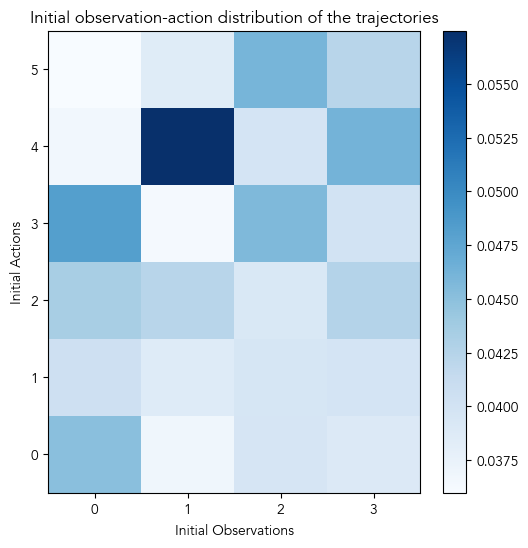

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

h, xedges, yedges = np.histogram2d(ya_array[:,0], ya_array[:,1], bins = [np.arange(-0.5, Y+0.5, 1), np.arange(-0.5, A+0.5, 1)])

pya_emp = h/np.sum(h)

Xgrid, Ygrid = np.meshgrid(xedges, yedges)

im = ax.pcolormesh(Xgrid, Ygrid, pya_emp.T, cmap = 'Blues')

ax.set_xlabel('Initial Observations')
ax.set_ylabel('Initial Actions')

ax.set_xticks(np.arange(0, Y, 1))
ax.set_yticks(np.arange(0, A, 1))

ax.set_title('Initial observation-action distribution of the trajectories')

plt.colorbar(im, ax = ax)

plt.show()

In [ ]:
pya = pAgY/Y

abs(pya - pya_emp).max()

5.310025864081053e-05

In [ ]:
L = np.zeros((Y, A))

for y in range(Y):
    for a in range(A):
        for m in range(M):
            L[y, a] += np.sum(FSC.TMat[y, :, m, a]*FSC.rho)
L

array([[0.18025605, 0.16227475, 0.17347578, 0.19289872, 0.14699234,
        0.14410236],
       [0.1473992 , 0.15453739, 0.16916189, 0.14527251, 0.23005417,
        0.15357484],
       [0.15783457, 0.15817979, 0.15747536, 0.18323256, 0.15903673,
        0.18424099],
       [0.15657302, 0.1593399 , 0.17023852, 0.1596325 , 0.18474138,
        0.16947468]])

In [ ]:
pAgY, abs(L - pAgY)

(array([[0.18064452, 0.16190633, 0.17367254, 0.19296717, 0.14677102,
         0.14403843],
        [0.14743006, 0.15481203, 0.16896934, 0.14516815, 0.2296724 ,
         0.15394803],
        [0.15839544, 0.15829626, 0.15691346, 0.18277805, 0.15912083,
         0.18449596],
        [0.15584808, 0.15913344, 0.17036846, 0.16014585, 0.18509291,
         0.16941126]]),
 array([[3.88463229e-04, 3.68424023e-04, 1.96754818e-04, 6.84519236e-05,
         2.21319641e-04, 6.39263069e-05],
        [3.08582074e-05, 2.74644095e-04, 1.92549239e-04, 1.04365241e-04,
         3.81774011e-04, 3.73186188e-04],
        [5.60867444e-04, 1.16471302e-04, 5.61898863e-04, 4.54507690e-04,
         8.40956974e-05, 2.54972110e-04],
        [7.24935922e-04, 2.06460238e-04, 1.29936695e-04, 5.13348298e-04,
         3.51533843e-04, 6.34226765e-05]]))

In [ ]:
FSC.rho

array([0.07376787, 0.04358095, 0.06250802, 0.14319657, 0.09552119,
       0.10248497, 0.03355936, 0.14864726, 0.1237556 , 0.17297819])

In [ ]:
wVec = FSC.TMat.sum(axis = 2)
qVec = np.exp(FSC.psi)
tempVec = np.zeros((Y, A, M))

for y in range(Y):
    for a in range(A):
        tempVec[y,a,:] = wVec[y, :, a]*qVec
        tempVec[y,a,:] = tempVec[y,a,:]/np.sum(tempVec[y,a,:])

rhoTilde = np.sum(pya[..., None]*tempVec, axis = (0,1))

constr = np.sum(qVec)*(pya[:, None, :]*wVec/np.sum(wVec*qVec[None, ..., None], axis = 1)[:, None, :]).sum(axis = (0, 2))

wVec_inferred = FSC_inferred.TMat.sum(axis = 2)
qVec_inferred = np.exp(FSC_inferred.psi)
tempVec_inferred = np.zeros((Y, A, M))

for y in range(Y):
    for a in range(A):
        tempVec_inferred[y,a,:] = wVec_inferred[y,:, a]*qVec_inferred
        tempVec_inferred[y,a,:] = tempVec_inferred[y,a,:]/np.sum(tempVec_inferred[y,a,:])

rhoTilde_inferred = np.sum(pya[..., None]*tempVec_inferred, axis = (0,1))

constr_inferred = np.sum(qVec_inferred)*(pya[:, None, :]*wVec_inferred/np.sum(wVec_inferred*qVec_inferred[None, ..., None], axis = 1)[:, None, :]).sum(axis = (0, 2))

qVec_rand = np.exp(np.random.randn(M))
tempVec_rand = np.zeros((Y, A, M))

for y in range(Y):
    for a in range(A):
        tempVec_rand[y,a,:] = wVec[y,:, a]*qVec_rand
        tempVec_rand[y,a,:] = tempVec_rand[y,a,:]/np.sum(tempVec_rand[y,a,:])

rhoTilde_rand = np.sum(pya[..., None]*tempVec_rand, axis = (0,1))
rho_rand = qVec_rand/np.sum(qVec_rand)

constr_rand = np.sum(qVec_rand)*(pya[:, None, :]*wVec/np.sum(wVec*qVec_rand[None, ..., None], axis = 1)[:, None, :]).sum(axis = (0, 2))

In [ ]:
FSC.rho - rhoTilde

array([-7.09641075e-06,  2.25093308e-06, -4.59661436e-06, -2.59618959e-05,
        1.59292793e-05,  4.48382880e-06,  3.71074294e-06,  6.86861553e-06,
       -1.02884352e-05,  1.46999566e-05])

In [ ]:
rhoTilde_inferred - FSC_inferred.rho

array([ 3.05553025e-04,  1.83445723e-05,  4.75238027e-04, -9.86929918e-04,
       -2.65772661e-05, -9.35373696e-05,  8.99507356e-05,  5.09943994e-04,
        5.10369680e-04, -8.02355480e-04])

In [ ]:
rho_rand - rhoTilde_rand

array([ 1.50691808e-03, -1.85647895e-04, -4.22332381e-05, -4.86372788e-04,
       -3.10025350e-04, -6.05251659e-04,  2.28467667e-04,  1.25955396e-03,
        1.66851693e-04, -1.53226047e-03])

In [ ]:
constr, constr_inferred, constr_rand

(array([1.00012166, 0.99983381, 1.00009473, 0.99995213]),
 array([0.99305445, 1.00869831, 0.9986437 , 1.00103598]),
 array([1.02973212, 0.97910465, 1.01508315, 1.02341132]))

In [ ]:
wVec = FSC.TMat.sum(axis = 2).transpose(0, 2, 1)
qVec = np.exp(FSC.psi)

c = qVec.sum()

tempVec = wVec/(wVec*qVec).sum(axis = -1)[..., None]
np.sum(pya[..., None]*tempVec, axis = (0,1)), 1/c

(array([0.06336062, 0.06335125, 0.06335918, 0.06336601, 0.06334396,
        0.06335175, 0.06334752, 0.0633516 , 0.06335979, 0.06334914]),
 0.06335452586566957)

In [ ]:
def fun_arg_rho_tilde(psi, wVec):
    qVec = np.exp(psi)
    return wVec/(wVec*qVec).sum(axis = -1)[..., None]

def fun_to_min(psi, c, wVec, pya):
    arg_rho_tilde = fun_arg_rho_tilde(psi, wVec)
    return np.sum(pya[..., None]*arg_rho_tilde, axis = (0,1)) - c

def fun_MSE(psi, c, wVec, pya):
    MSE = fun_to_min(psi, c, wVec, pya)**2
    return np.sum(np.sqrt(MSE))

def fun_jac(psi, wVec, pya):
    M = len(psi)
    qVec = np.exp(psi)
    norm = (wVec*qVec).sum(axis = -1)

    jac = np.zeros((M, M))

    for nu in range(M):
        for mu in range(M):
            temp = wVec[:, :, mu]*wVec[:, :, nu]*np.exp(psi[nu])
            temp /= norm**2

            jac[mu, nu] = -np.sum(pya*temp)
    
    return jac

def MSE_jac(psi, c, wVec, pya):

    f = fun_to_min(psi, c, wVec, pya)
    jac = fun_jac(psi, wVec, pya)

    fsqrt = f/np.sqrt(f**2)

    return np.sum(fsqrt*jac, axis = 0)


def fun_hess(psi, wVec, pya):
    M = len(psi)
    qVec = np.exp(psi)
    norm = (wVec*qVec).sum(axis = -1)

    jac = fun_jac(psi, wVec, pya)
    hess = np.zeros((M, M, M))

    for nu in range(M):
        for mu in range(M):
            for beta in range(M):
                temp = wVec[:, :, mu]*wVec[:, :, nu]*wVec[:, :, beta]*np.exp(psi[nu])*np.exp(psi[beta])
                temp /= norm**4

                hess[mu, nu, beta] = -2*np.sum(pya*temp)

                if beta == nu:
                    hess[mu, nu, beta] += jac[mu, nu]
    
    return jac

def MSE_hess(psi, c, wVec, pya):

    f = fun_to_min(psi, c, wVec, pya)
    jac = fun_jac(psi, wVec, pya)
    hes = fun_hess(psi, wVec, pya)

    return 2*np.dot(jac.T, jac) + 2*np.sum(f[..., None, None]*hes, axis = 0)

from scipy.optimize import minimize

psi0 = np.zeros(M)


In [ ]:
res = minimize(fun_MSE, psi0, args = (1/c, wVec, pya), method = 'L-BFGS-B', tol = 1e-15)

In [ ]:
res2 = minimize(fun_MSE, psi0, args = (1, wVec, pya), method = 'L-BFGS-B', tol = 1e-15)

In [ ]:
res3 = minimize(fun_MSE, psi0, args = (1, wVec, pya), method = 'L-BFGS-B', jac = MSE_jac, tol = 1e-15)

In [ ]:
psi_opt = res.x
psi_opt2 = res2.x
psi_opt3 = res3.x

In [ ]:
import fun
fun.softmax(psi_opt), fun.softmax(psi_opt2), fun.softmax(psi_opt3), fun.softmax(FSC.psi)

(array([0.07152899, 0.06046894, 0.05483122, 0.12727459, 0.08489357,
        0.10139924, 0.04353451, 0.1419685 , 0.1353814 , 0.17871904]),
 array([0.07152899, 0.06046894, 0.05483122, 0.12727459, 0.08489357,
        0.10139924, 0.04353451, 0.1419685 , 0.1353814 , 0.17871904]),
 array([0.07231553, 0.07198372, 0.07210601, 0.10958484, 0.09932054,
        0.10042422, 0.07256131, 0.13584714, 0.11268077, 0.15317592]),
 array([0.07376787, 0.04358095, 0.06250802, 0.14319657, 0.09552119,
        0.10248497, 0.03355936, 0.14864726, 0.1237556 , 0.17297819]))

In [ ]:
psi_opt, psi_opt2, psi_opt3, FSC.psi

(array([-2.63753351, -2.80550643, -2.90337647, -2.06128945, -2.4662379 ,
        -2.28857066, -3.13408244, -1.95203106, -1.99954034, -1.72182132]),
 array([-2.63753351, -2.80550643, -2.90337647, -2.06128945, -2.4662379 ,
        -2.28857066, -3.13408244, -1.95203106, -1.99954034, -1.72182132]),
 array([-2.62682383, -2.63142263, -2.62972525, -2.21116364, -2.30951033,
        -2.2984593 , -2.62343079, -1.99633238, -2.1833039 , -1.87627562]),
 array([ 0.15217698, -0.37412632, -0.01345147,  0.81547197,  0.41060179,
         0.48096985, -0.63543044,  0.85282977,  0.66956234,  1.00441919]))

In [ ]:
print("True rho: ", FSC.rho)
print("Rho tilde: ", rhoTilde)
print()
print("Inferred rho: ", FSC_inferred.rho)
print("Inferred rho tilde: ", rhoTilde_inferred)
print()
print("Random rho tilde: ", rhoTilde_rand)

True rho:  [0.07376787 0.04358095 0.06250802 0.14319657 0.09552119 0.10248497
 0.03355936 0.14864726 0.1237556  0.17297819]
Rho tilde:  [0.07377497 0.04357869 0.06251262 0.14322253 0.09550526 0.10248049
 0.03355565 0.14864039 0.12376589 0.17296349]

Inferred rho:  [0.0489095  0.01694178 0.0781651  0.22879293 0.10484564 0.10724914
 0.00939004 0.03848617 0.15224166 0.21497804]
Inferred rho tilde:  [0.04921506 0.01696012 0.07864034 0.22780601 0.10481907 0.1071556
 0.00947999 0.03899611 0.15275203 0.21417569]

Random rho tilde:  [0.16186581 0.06851609 0.03399262 0.05930545 0.11016237 0.05721134
 0.05618301 0.21479124 0.1128547  0.12511738]


In [ ]:
print("True rho, sorted:", np.sort(FSC.rho))
print("Rho tilde, sorted:", np.sort(rhoTilde))

print()

print("Inferred rho, sorted:", np.sort(FSC_inferred.rho))
print("Inferred rho tilde, sorted:", np.sort(rhoTilde_inferred))

print()

print("Random rho tilde, sorted:", np.sort(rhoTilde_rand))

True rho, sorted: [0.18754124 0.23845104 0.2633924  0.31061532]
Rho tilde, sorted: [0.18756406 0.23841141 0.26337979 0.31064474]

Inferred rho, sorted: [0.19523337 0.22358631 0.2687734  0.31240692]
Inferred rho tilde, sorted: [0.19693157 0.22203338 0.26905184 0.3119832 ]

Random rho tilde, sorted: [0.05689319 0.09290501 0.39116834 0.45903346]


In [ ]:
import autograd
import autograd.numpy as anp

psi_g = anp.array(FSC.psi)
TMat_g = anp.array(FSC.TMat)
pya_g = anp.array(pya)

def rho_g_func(psi_g):
    rho_g = anp.exp(-psi_g)
    rho_g = rho_g / anp.sum(rho_g)
    return rho_g

def likelihood(pya, TMat, psi):
    rho = rho_g_func(psi)
    wVec = anp.sum(TMat, axis=2).transpose(0, 2, 1)

    L = anp.dot(wVec, rho)

    return -anp.sum(pya * anp.log(L))

grad_rho_g = autograd.jacobian(rho_g_func)
grad_likelihood = autograd.grad(likelihood, argnum=2)

grad_likelihood(pya_g, TMat_g, psi_g)

array([-0.00556989,  0.00083398,  0.00262666,  0.00210925])

In [ ]:
grad_likelihood(pya_g, TMat_g, anp.random.randn(M))

array([ 0.0016102 , -0.00508688,  0.00191143,  0.00156526])

In [ ]:
rho_g = rho_g_func(psi_g)
wVec = anp.sum(TMat_g, axis=2).transpose(0, 2, 1)
anp.dot(wVec, rho_g).shape

(5, 3)

# Finite State Controller with $M = 8$, $A = 7$, $Y = 5$

# Observations, one step

In [ ]:
NStepsObs = 1
NTraj = 3000
Y = 5
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 3)

In [ ]:
M = 8
A = 7

np.random.seed(9)
Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 8 memory states, 7 actions, and 5 observations.


In [ ]:
FSC.load_observations(observations)

In [ ]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

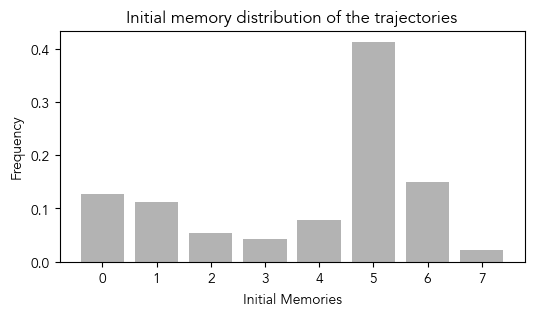

In [ ]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(6,3))

h, bins_h = np.histogram(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1))
h = h/np.sum(h)
bins_h = (bins_h[1:] + bins_h[:-1])/2

ax.bar(bins_h, h, width = 0.8, color = 'dimgray', alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

ax.set_title('Initial memory distribution of the trajectories')

plt.show()

In [ ]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.4681756798545755

### Inference

In [ ]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 42, minus1_opt = False)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(1.6269, device='mps:0', grad_fn=<SubBackward0>)

In [ ]:
psi_pre_fit = FSC_tofit.psi.detach().cpu().numpy()
rho_pre_fit = FSC_tofit.rho.detach().cpu().numpy()

In [ ]:
tloss, vloss = FSC_tofit.optimize_psionly(NEpochs = 100, NBatch = 400, lr = 0.01, gamma = 0.99)

Training with 2400 trajectories and validating with 600 trajectories.
Epoch 1 - Training loss: 1.938591842651367, Validation loss: 1.9297829888264337 - Learning rate: 0.01
Epoch 2 - Training loss: 1.937333450317383, Validation loss: 1.9288926881551742 - Learning rate: 0.0099
Epoch 3 - Training loss: 1.9362227376302084, Validation loss: 1.9280485343933105 - Learning rate: 0.009801
Epoch 4 - Training loss: 1.9353133900960289, Validation loss: 1.927216246922811 - Learning rate: 0.00970299
Epoch 5 - Training loss: 1.9344055938720703, Validation loss: 1.9264730761448543 - Learning rate: 0.0096059601
Epoch 6 - Training loss: 1.9334988911946613, Validation loss: 1.925833835999171 - Learning rate: 0.009509900499
Epoch 7 - Training loss: 1.932799377441406, Validation loss: 1.9252493053674697 - Learning rate: 0.00941480149401
Epoch 8 - Training loss: 1.9320687103271483, Validation loss: 1.924760310848554 - Learning rate: 0.0093206534790699
Epoch 9 - Training loss: 1.9315320587158205, Validation 

### Comparison

In [ ]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 8 memory states, 7 actions, and 5 observations.


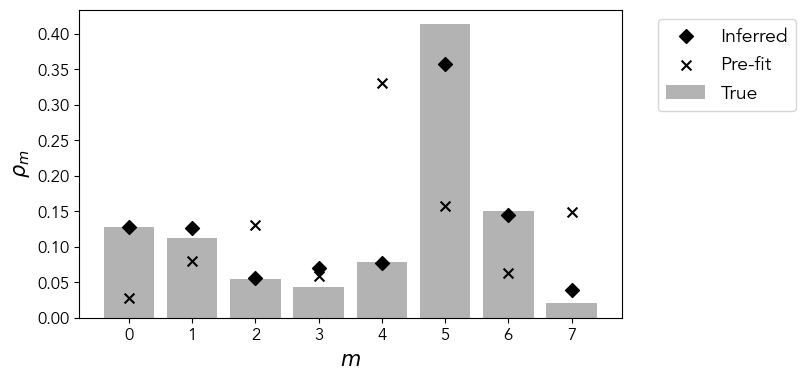

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(bins_h, h, color = "dimgray", alpha = 0.5, label = "True")
ax.scatter(np.arange(M), FSC_inferred.rho, color = "black", marker = "D", s = 50, label = "Inferred")
ax.scatter(np.arange(M), rho_pre_fit, color = "black", marker = "x", s = 50, label = "Pre-fit")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()